In [1]:
import tskit
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import sparg

In [2]:
ts = tskit.load("rep1_S025_I1_R2_W100_D2_long.trees")

In [3]:
s = []
for sample in ts.samples():
    location = ts.individual(ts.node(sample).individual).location
    s.append([sample, location[0], location[1], math.sqrt((location[0] - 500)**2 + (location[1] - 500)**2)])
s = pd.DataFrame(s, columns=["s", "x", "y", "d"])
s = s.sort_values("d", ascending=False)

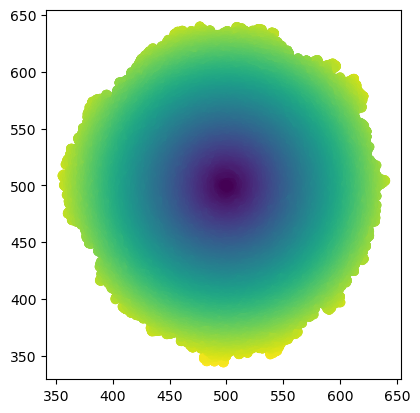

In [4]:
fig = plt.figure()
plt.scatter(s["x"], s["y"], c=s["d"])
plt.gca().set_aspect("equal")
plt.show()

In [5]:
s.head(1000)

,s,x,y,d
26527,26527,497.413389,344.281057,155.740424
26526,26526,497.413389,344.281057,155.740424
86807,86807,482.724001,345.297886,155.663754
86806,86806,482.724001,345.297886,155.663754
92414,92414,497.270596,344.506606,155.517347
...,...,...,...,...
14221,14221,501.559301,356.790171,143.218318
8195,8195,489.564135,357.175360,143.205394
8194,8194,489.564135,357.175360,143.205394
15015,15015,436.204306,371.797309,143.198536


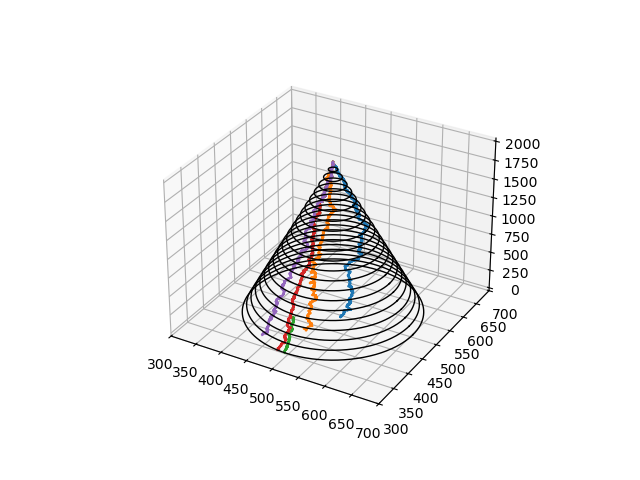

In [6]:
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in [0, 1000, 26526, 86806, 15015]:
    path = [i] + list(sparg.ancestors(ts.first(), i))
    times = []
    xs = []
    ys = []
    for node in path:
        indiv = ts.node(node).individual
        if indiv != -1:
            xs.append(ts.individual(indiv).location[0])
            ys.append(ts.individual(indiv).location[1])
            times.append(ts.node(node).time)
    plt.plot(xs, ys, times)

v = s.iloc[0].d / 2000
starting_radius = s.iloc[0].d
for time in range(0, 2100, 100):
    xs = []
    ys = []
    times = []
    radius = starting_radius - v*time
    for angle in range(0, 361):
        xs.append(radius*math.cos(math.radians(angle)) + 500)
        ys.append(radius*math.sin(math.radians(angle)) + 500)
        times.append(time)
    plt.plot(xs, ys, times, linewidth=1, color="black")
    
plt.xlim(300, 700)
plt.ylim(300, 700)
plt.show()

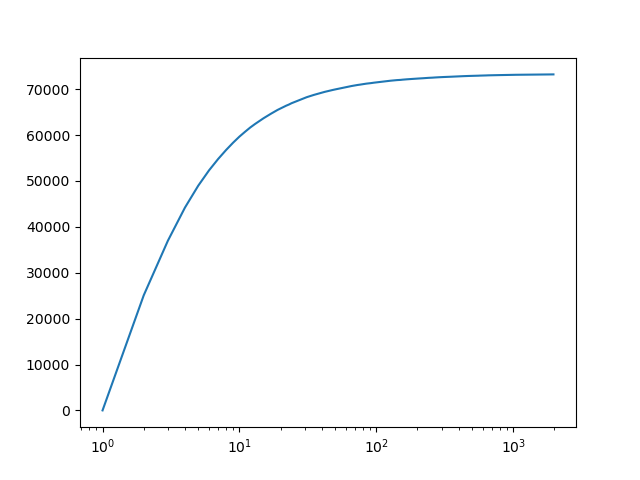

In [7]:
times = []
cumlative = []
counter = 0
ts_sim = ts.simplify()
tree = ts_sim.first()
current_time = 0
for node in tree.nodes(order="timeasc"):
    if not tree.is_sample(node):
        node_time = tree.time(node)
        if node_time != current_time:
            times.append(tree.time(node))
            cumlative.append(counter)
            current_time = node_time
        counter += 1
fig = plt.figure()
plt.plot(times, cumlative)
plt.xscale("log")
plt.show()

In [46]:
from scipy.stats import vonmises

In [127]:
np.random.seed(1)
nsamples = 100
keep_nodes = list(np.random.choice(ts.samples(),nsamples, replace=False))

#FULL ARG
ts_sim, sim_map = ts.simplify(samples=keep_nodes, keep_input_roots=False, keep_unary=True, map_nodes=True)
ts_filtered, filtered_maps = sparg.simplify_with_recombination(ts=ts_sim)
FullARG = sparg.SpatialARG(ts=ts_filtered, dimensions=2, verbose=False)
path_matrix = FullARG.paths_shared_time_matrix
P = np.zeros((len(path_matrix), nsamples))
for path_id, path in enumerate(FullARG.paths) : 
    P[path_id][path[0]] = 1 
inverted_paths_matrix = FullARG.inverted_paths_shared_time_matrix
inverse_sample_covariance_matrix = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),P)

R = FullARG.roots_array
RP = np.matmul(np.matmul(np.transpose(P),inverted_paths_matrix),R)


sigma_squared = np.array([[0.5625]])#np.array([[0.5625,0.0],[0.0,0.5625]])
sample_covariance_matrix = np.kron(np.linalg.inv(inverse_sample_covariance_matrix),sigma_squared)

sample_locations = np.matmul(np.linalg.inv(inverse_sample_covariance_matrix), np.matmul(RP,np.array([list(FullARG.root_locations.values())[0][0]]))).reshape(1,100)[0]
simulated = np.random.multivariate_normal(mean = sample_locations, cov =sample_covariance_matrix )

print(sample_locations.shape)
print(sample_covariance_matrix.shape)
print(simulated.shape)
print(simulated)

(100,)
(100, 100)
(100,)
[483.87566933 468.82897417 495.12947422 459.62760311 487.64701537
 504.96027237 471.491074   517.83147839 453.28701222 479.14584448
 507.56656453 488.21839956 452.00644604 486.5043939  501.24307198
 495.07774277 497.91960132 552.26019036 475.58406909 454.29970924
 487.58178944 515.0605975  492.66964826 511.47907906 499.09499115
 509.82218546 506.86243467 554.64262223 476.77013744 503.04981735
 502.94740979 535.20531277 530.72761958 439.00819191 556.75901735
 545.53168688 455.96375376 500.68846309 483.48612326 508.15113158
 528.20690846 481.60252778 476.27704576 525.65041347 516.01899518
 486.01847012 464.45955932 489.07961682 547.29001049 510.92205482
 553.38939985 510.31181138 488.10579707 444.46484114 513.08512434
 471.88534302 457.05778699 559.20922333 435.00228759 464.2179434
 443.85356265 458.88968161 446.07116564 520.15080023 535.43005571
 543.39384437 517.14248835 500.93306172 463.19768808 502.84764671
 520.89449042 502.6740735  447.07734792 523.75074011

In [126]:
np.random.vonmises(np.array([i for i in [0, 1]]), np.array([[10,1],[1,10]])) #np.array([[10,1],[1,10]]))

array([[-0.13378536,  0.89314966],
       [-2.42673399,  0.34019818]])

In [53]:
sample_size = 2
#sample = vonmises(loc=np.array([]), kappa=1).rvs(2)

print(sample)

#print(vonmises.var(1, loc=0, scale=1))

#print(1/1)

[-0.03433762 -2.37136896]


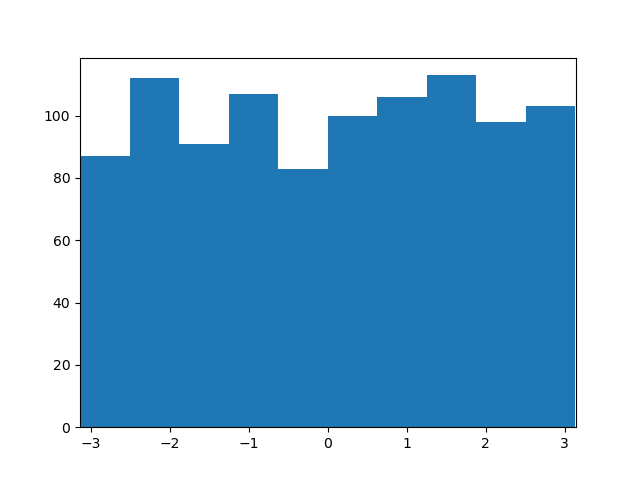

In [33]:
fig = plt.figure()
plt.hist(sample)
plt.xlim(-math.pi, math.pi)
plt.show()